In [24]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import kde
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold

In [27]:
calibration_data = pd.read_csv("R 2 sigurd/PCA_CALIBRATION_2.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/R 2 sigurd/PCA_CALIBRATION_2.csv'

In [ ]:

X = calibration_data.iloc[:,4:406]
y = calibration_data.iloc[:,406].values


#PCA
pca_model = PCA(n_components= 13)

pca_model.fit(X)


X_pca = pca_model.transform(X)

# VALIDATING R-studio results in Python using calibration/validation data. 

First we will calculate mean AUC scores across cross validation. 

In [ ]:
lda = LinearDiscriminantAnalysis()
#kf = KFold(n_splits= 10, shuffle= True)

kf = StratifiedKFold(n_splits= 10 , shuffle= True)


roc_scores_list = []

for i in range(20):
    for train, test in kf.split(X_pca, y):
        lda.fit(X_pca[train,:], y[train])
        y_score_lda1 = lda.decision_function(X_pca[test,:])
        roc_scores_list.append(roc_auc_score(y[test], y_score_lda1))
    print(np.mean(roc_scores_list))

0.8241617387789588
0.8239549434826825
0.823879952743544
0.8239871013633193
0.8237695065589279
0.8236414848870938
0.8236514091969593
0.8237238571958446
0.8235641215852657
0.8235715807431855
0.8235558981572105
0.82348442095012
0.8234286636454065
0.8234186306449324
0.8234697650213657
0.823373304154088
0.8233739407213844
0.823372301614773
0.8234145446952221
0.8234113028513506


In [ ]:
y_2 = np.zeros(shape = len(y))
for i in range(len(y)):
    if y[i] == "Central":
        y_2[i] = 0
    else: 
        y_2[i] = 1


array([0., 1., 1., ..., 0., 0., 0.])

## Create the ROC curve 

Creating ROC curves for validation/calibration data with all features included. 

In [ ]:
lda = LinearDiscriminantAnalysis()
kf = KFold(n_splits= 10, shuffle= True)


for train, test in kf.split(X_pca):
    lda.fit(X_pca[train,:], y_2[train])
    y_score_lda1 = lda.decision_function(X_pca[test,:])
    fpr, tpr, _ = roc_curve(y_2[test], y_score_lda1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr,tpr,
        color="darkorange",lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

NameError: name 'y_2' is not defined

# Testing their lda and pca model on our spivey replication data. 

In [ ]:
spivey_data = pd.read_csv("R 2 sigurd/spivey_data_for_pca.csv")
#X
X_spivey = spivey_data.iloc[:,4:405]
X_spivey['a101'] = 0
#transform
X_spivey_pca = pca_model.transform(X_spivey)

#Y
y_spivey = spivey_data.iloc[:,2]

y_spivey2 = np.zeros(shape = len(y_spivey))

for i in range(len(y_spivey)):
    if y_spivey[i] == "Central":
        y_spivey2[i] = 0
    else: 
        y_spivey2[i] = 1


In [ ]:

lda = LinearDiscriminantAnalysis()

#Fit lda on Calibration data
lda.fit(X_pca, y)

#predict on Spivey data 
lda.predict(X_spivey_pca)
lda.score(X_spivey_pca, y_spivey2)

#get lda values. 
spivey_data["lda_value"] = lda.transform(X_spivey_pca)


/Users/sigurd/opt/anaconda3/envs/method3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:211: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


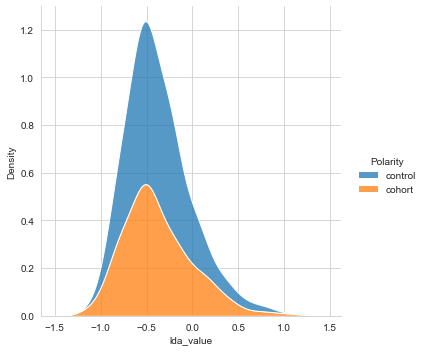

In [ ]:
import seaborn as sns

sns.set_style('whitegrid')
sns.displot(spivey_data, x = "lda_value", hue = "Polarity", kind = "kde", multiple = "stack")

In [ ]:
y_score_lda = lda.fit(X_pca, y).decision_function(X_spivey_pca) #fit on validation data # test on Spivey data

In [ ]:
roc_auc_score(y_spivey, y_score_lda)

0.5111683122264741

In [ ]:
lda = LinearDiscriminantAnalysis()
kf = KFold(n_splits= 10, shuffle= True)


for train, test in kf.split(X_pca):
    lda.fit(X_spivey_pca[train,:], y_spivey2[train])
    y_score_lda1 = lda.decision_function(X_spivey_pca[test,:])
    fpr, tpr, _ = roc_curve(y_spivey2[test], y_score_lda1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr,tpr,
        color="darkorange",lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

IndexError: index 872 is out of bounds for axis 0 with size 872